**Nombres:** Valentina Hernandez Quintana y Laura Alejandra Rincón Castaño.

#  **Reconstrucción 3D a partir de imágenes usando Structure from Motion (SfM)**

## **Librerías**

In [ ]:
!pip install pycolmap open3d opencv-python numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Atte

In [ ]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import pycolmap

## **Preprocesamiento de Imágenes**

Como primer paso, cargamos las imágenes desde la carpeta `imagenes/construccion3D`, luego las convertimos a escala de grises y las almacenamos en una lista para su posterior procesamiento en la reconstrucción 3D.

In [ ]:
carpetaImagenes = '/content/drive/MyDrive/Visión por computadora/Construccion3D'

In [ ]:
def cargarImagenes(path):
    imagenes = []
    for archivo in sorted(os.listdir(path)):
        img_path = os.path.join(path, archivo)
        imagen = cv2.imread(img_path)
        if imagen is not None:
            imagenes.append(imagen)
    return imagenes

imagenes = cargarImagenes(carpetaImagenes)

In [ ]:
def preprocesarImagenes(imagenes):
    procesadas = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imagenes]
    return procesadas

imagenesGris = preprocesarImagenes(imagenes)

## **Detección de Características y Emparejamiento**

Ahora se detectan y emparejan características en las imágenes preprocesadas utilizando SIFT y BFMatcher. Luego, se visualizan los puntos clave y sus emparejamientos entre imágenes consecutivas. Para esto, creamos funciones que permiten representar gráficamente los resultados y analizar las correspondencias detectadas.

In [ ]:
def detectar_y_emparejar(imagenes):
    sift = cv2.SIFT_create()
    keypoints_descriptors = [sift.detectAndCompute(img, None) for img in imagenes]
    bf = cv2.BFMatcher()
    emparejamientos = []
    for i in range(len(imagenes) - 1):
        matches = bf.knnMatch(keypoints_descriptors[i][1], keypoints_descriptors[i+1][1], k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        emparejamientos.append(good_matches)
    return keypoints_descriptors, emparejamientos

keypoints_descriptors, emparejamientos = detectar_y_emparejar(imagenesGris)

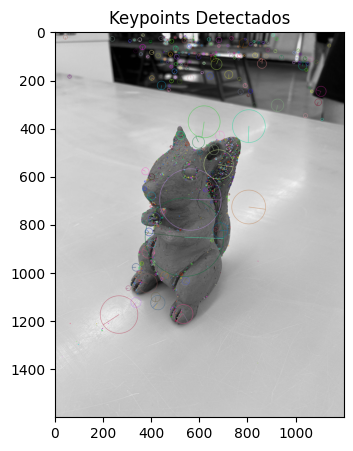

In [ ]:
def visualizar_keypoints(imagen, keypoints):
    img_keypoints = cv2.drawKeypoints(imagen, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10,5))
    plt.imshow(img_keypoints, cmap='gray')
    plt.title("Keypoints Detectados")
    plt.show()

visualizar_keypoints(imagenesGris[0], keypoints_descriptors[0][0])

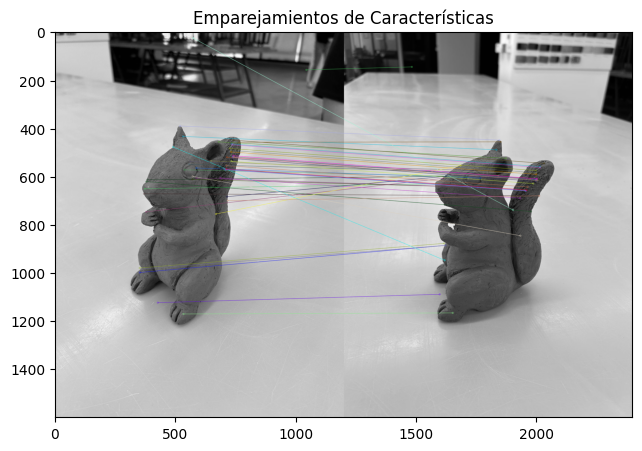

In [ ]:
def visualizar_emparejamientos(img1, kp1, img2, kp2, matches):
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(10,5))
    plt.imshow(img_matches)
    plt.title("Emparejamientos de Características")
    plt.show()

visualizar_emparejamientos(imagenesGris[0], keypoints_descriptors[0][0], imagenesGris[1], keypoints_descriptors[1][0], emparejamientos[0])

## **Estimación de la Matriz Fundamental y la Matriz Esencial**  

Ahora, siguiendo el procedimiento de la tarea 1, se calibró la cámara mediante imágenes de un tablero de ajedrez. Estas imágenes están ubicadas en la carpeta `imagenes\calibracion`.

In [ ]:
boardSize = (7, 7)
squareSize = 18

objp = np.zeros((boardSize[0] * boardSize[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:boardSize[0], 0:boardSize[1]].T.reshape(-1, 2) * squareSize

objPuntos = []
imgPuntos = []

images = glob.glob("/content/drive/MyDrive/Visión por computadora/calibracion/*.jpeg")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, boardSize, None)

    if ret:
        objPuntos.append(objp)
        imgPuntos.append(corners)

ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objPuntos, imgPuntos, gray.shape[::-1], None, None)

print("Matriz de la cámara:")
print(K)

Matriz de la cámara:
[[1.19790278e+03 0.00000000e+00 6.28108146e+02]
 [0.00000000e+00 1.19637666e+03 8.11735026e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Ahora, utilizamos RANSAC para estimar la matriz fundamental entre dos imágenes emparejadas. Con esta matriz, filtramos los emparejamientos para conservar únicamente aquellos puntos clave que son consistentes, eliminando así posibles errores o outliers. Y a su vez se estima la matriz esencial teniendo en cuenta la matriz de calibración de la cámara. La matriz esencial nos permite recuperar la información de rotación (R) y traslación (t) entre las dos vistas, lo que es fundamental para determinar la posición relativa de las cámaras y reconstruir la escena en 3D.

In [ ]:
def estimar_matriz_fundamental_y_esencial(kp1, kp2, matches, K):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Matriz Fundamental con RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    pts1_inliers = pts1[mask.ravel() == 1]
    pts2_inliers = pts2[mask.ravel() == 1]

    # Matriz Esencial E = K^T * F * K
    E = K.T @ F @ K

    # Descompone E en R y t
    _, R, t, _ = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

    return F, E, R, t, pts1_inliers, pts2_inliers

F, E, R, t, pts1_inliers, pts2_inliers = estimar_matriz_fundamental_y_esencial(
    keypoints_descriptors[0][0], keypoints_descriptors[1][0], emparejamientos[0], K)

print("Matriz Fundamental (F):\n", F)
print("\nMatriz Esencial (E):\n", E)
print("\nRotación (R):\n", R)
print("\nTraslación (t):\n", t)

Matriz Fundamental (F):
 [[-3.25561481e-07  1.76483802e-07  5.53378668e-04]
 [ 3.85185560e-06  1.69828737e-07 -7.22454348e-03]
 [-1.22675478e-03  4.28275628e-03  1.00000000e+00]]

Matriz Esencial (E):
 [[-0.46717131  0.25292651  0.58954658]
 [ 5.5202596   0.24307878 -5.58385555]
 [ 2.0309765   5.4213367   0.22643588]]

Rotación (R):
 [[ 0.62231243 -0.37833904  0.68526404]
 [ 0.32279159  0.92157104  0.21566735]
 [-0.71311488  0.086985    0.69562978]]

Traslación (t):
 [[-0.99339429]
 [-0.10281677]
 [ 0.05095576]]


## **Reconstrucción 3D**

Para la reconstrucción 3D, instalamos el software COLMAP localmente en nuestro dispositivo y utilizamos su interfaz gráfica (GUI) para llevar a cabo el proceso de reconstrucción. Los resultados generados se encuentran en el archivo `src/reconstruction.ply`. A continuación, se muestra cómo luce el modelo después de completar la reconstrucción desde la interfaz gráfica.



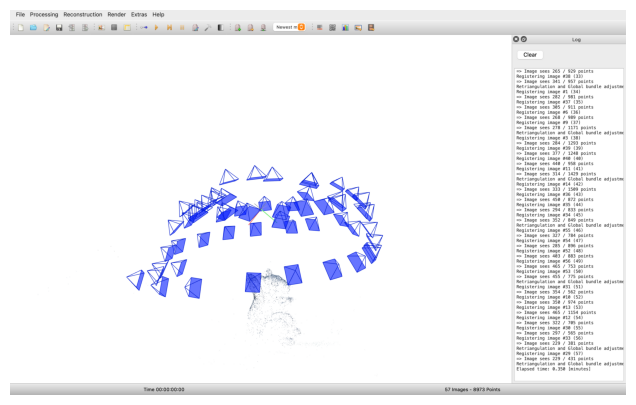

In [ ]:
ruta_imagen = "/content/drive/MyDrive/Visión por computadora/reconstruccionCOLMAP.png"

plt.figure(figsize=(10, 5))
plt.imshow(cv2.imread(ruta_imagen))
plt.axis("off")
plt.show()

## **Visualización del Modelo 3D**

In [ ]:
archivo_ply = "/content/drive/MyDrive/Visión por computadora/reconstruction.ply"
nube_puntos = o3d.io.read_point_cloud(archivo_ply)

puntos = np.asarray(nube_puntos.points)
o3d.visualization.draw_geometries([nube_puntos])

[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
